# Load Data
Load the driving data set

In [1]:
import numpy as np
import h5py

hf = h5py.File('../dataset/recording1_remap.h5', 'r')

video = hf.get('video')
command = hf.get('command')

image = video.get('image')

steer = command.get('steering')
throttle = command.get('throttle')
gear = command.get('gear_shift')
cmd_stamp = video.get('timestamp')


print(image.shape)
print(steer.shape)

(850, 180, 240, 3)
(850,)


# Visualize Data
View a sample from the dataset

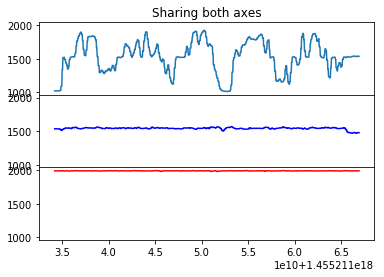

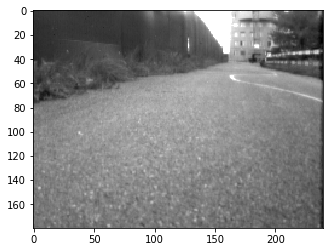

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

f , (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)

ax1.plot(cmd_stamp,steer,linestyle="-")
ax1.set_title('Sharing both axes')
ax2.plot(cmd_stamp,throttle, color='b')
ax3.plot(cmd_stamp,gear, color='r')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

plt.figure()
plt.imshow(image[1,:,:,:])
plt.show()

# Preprocessing Data
Shuffle the training data.

In [3]:
from sklearn.utils import shuffle
import pandas as pd
import random
import time



def shuffle_time():
    t1 = time.time()
    random.shuffle(hf['steering'])
    t2 = time.time()
    print('Time to shuffle: {:.3f} seconds'.format(str(t2 - t1)))
    
train_X = np.array(image)
train_Y = np.array(steer)

n_samples = train_X.shape[0]

print(n_samples)
#suffle_steer = shuffle_time()

#csv = pd.read_hdf('../dataset/recording1_remap.h5', index_col=False)
#X_train, y_train = shuffle(image, steer)

850


# Setup TensorFlow

In [4]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 32

# LeNet-5

In [5]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(38304, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 1), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(1))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Features and Labels
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [6]:
x = tf.placeholder(tf.float32, (None, 180, 240, 3))
y = tf.placeholder(tf.float32, (None))

# Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [7]:
rate = 0.001

pred = LeNet(x)
cost = tf.reduce_sum(tf.pow(pred-y, 2))/(2*n_samples)

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
#loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(cost)

# Model Evalution
Evaluate how well the loss and accuracy of the model for a given dataset.

In [8]:
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_X)

    print("Training...")
    print()
    for i in range(EPOCHS):
        train_X, train_Y = shuffle(train_X, train_Y)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_X[offset:end], train_Y[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        
        c = sess.run(cost, feed_dict={x: train_X, y:train_Y})
        print("Epoch:", '%04d' % (i+1), "cost=", "{:.9f}".format(c))
            
        #validation_accuracy = evaluate(X_validation, y_validation)
        #print("EPOCH {} ...".format(i+1))
        #print("loss {:.3f} ...".format(cost))
        #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

Epoch: 0001 cost= 29276816.000000000

Epoch: 0002 cost= 24999676.000000000

Epoch: 0003 cost= 24099378.000000000



KeyboardInterrupt: 